# Making a Webtoon Corpus Testing

## Installation

In [ ]:
!apt install tesseract-ocr libtesseract-dev libleptonica-dev pkg-config tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
libleptonica-dev is already the newest version (1.75.3-3).
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr-kor is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install pillow pytesseract


In [ ]:
from PIL import Image
import pytesseract

In [ ]:
print(pytesseract.get_languages(config=''))

['kor', 'eng', 'osd']


## First pass to get the text recognized

In [ ]:
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow
from difflib import SequenceMatcher

opener=urllib.request.build_opener()
opener.addheaders=[('User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)

urllib.request.urlretrieve("https://image-comic.pstatic.net/webtoon/748105/131/20211124111925_fa0d5663494d9ce21c0150859afffe18_IMAG01_1.jpg", "sample.jpg")
#req = urllib.request.urlopen('https://image-comic.pstatic.net/webtoon/748105/131/20211124111925_fa0d5663494d9ce21c0150859afffe18_IMAG01_1.jpg')
#arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
#img = cv2.imdecode(arr, -1) # 'Load it as it is'
img = cv2.imread('sample.jpg')
actual_text = '''고속도로 첫 운전으로 도착한 곳은 
외고모할머니 댁이었다 
고모~ 
아이고 
아도 같이 왔네~ 
막 운전 배우기 시작한 아 (29) 
외고모할머니께서 직접 농사지으신
베추를 얻어 가기 위해서였다'''
py_text = pytesseract.image_to_string(img, lang='kor', config = '--psm 11')
print('Actual Text')
print(actual_text)
print('Pytesseract Text')
print(py_text)
s = SequenceMatcher(lambda x: x == " ",
                    py_text,
                    actual_text)
print(round(s.ratio(), 3))

Actual Text
고속도로 첫 운전으로 도착한 곳은 
외고모할머니 댁이었다 
고모~ 
아이고 
아도 같이 왔네~ 
막 운전 배우기 시작한 아 (29) 
외고모할머니께서 직접 농사지으신
베추를 얻어 가기 위해서였다
Pytesseract Text
고속도로 첫 운전으로 도착한 곳은

외고모할머니 택이었다

토

[2

아이고

아도 같이 왔네~

의 고모할리니기시 기기

201904069

기 (^

^

트 1

0.502


The accuracy right now is only .502 so we will see if through image processing we can improve the accuracy. Below is the actual image.



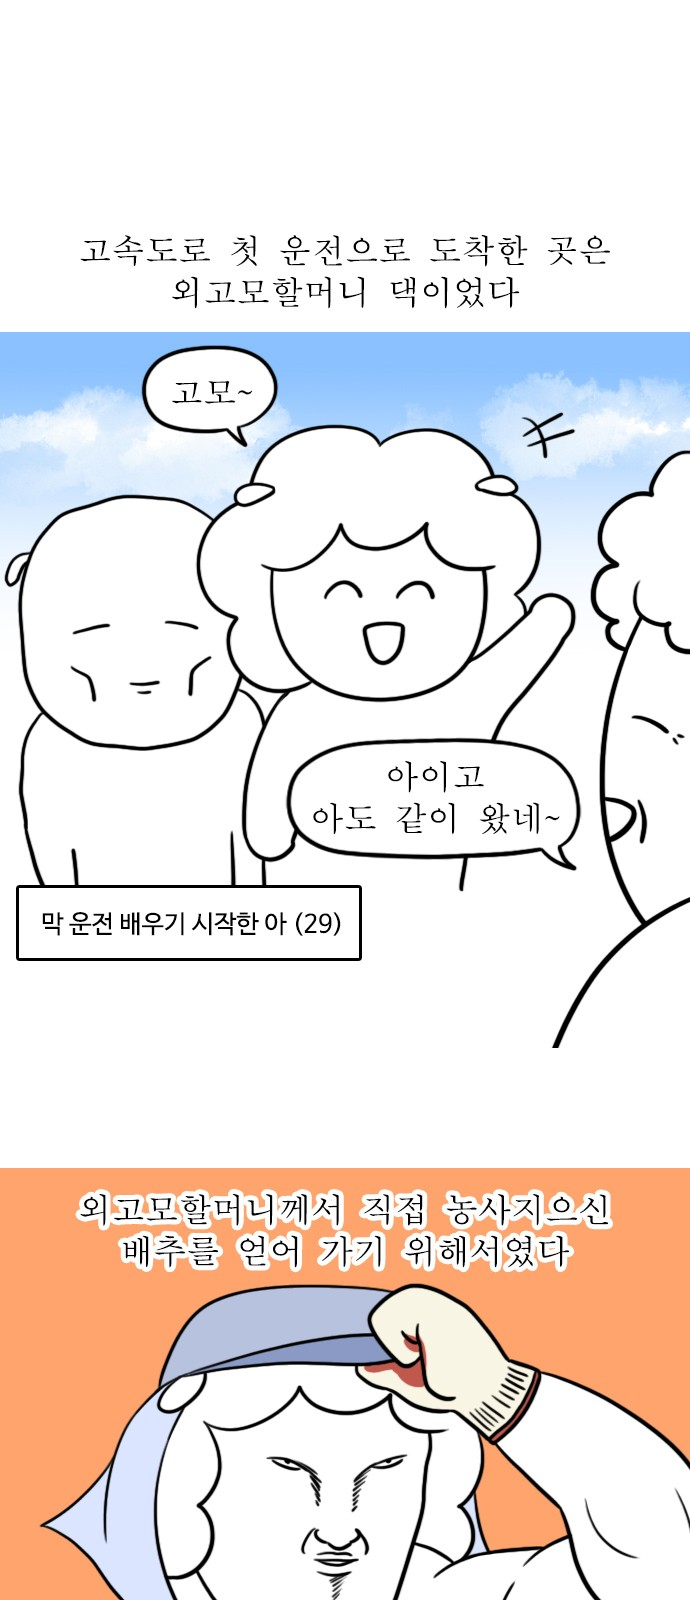

In [ ]:
cv2_imshow(img)
if cv2.waitKey() & 0xff == 27: quit()

## Attempting to clean image to get better results

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [ ]:
gray = get_grayscale(img)
noise = remove_noise(img)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

TypeError: ignored

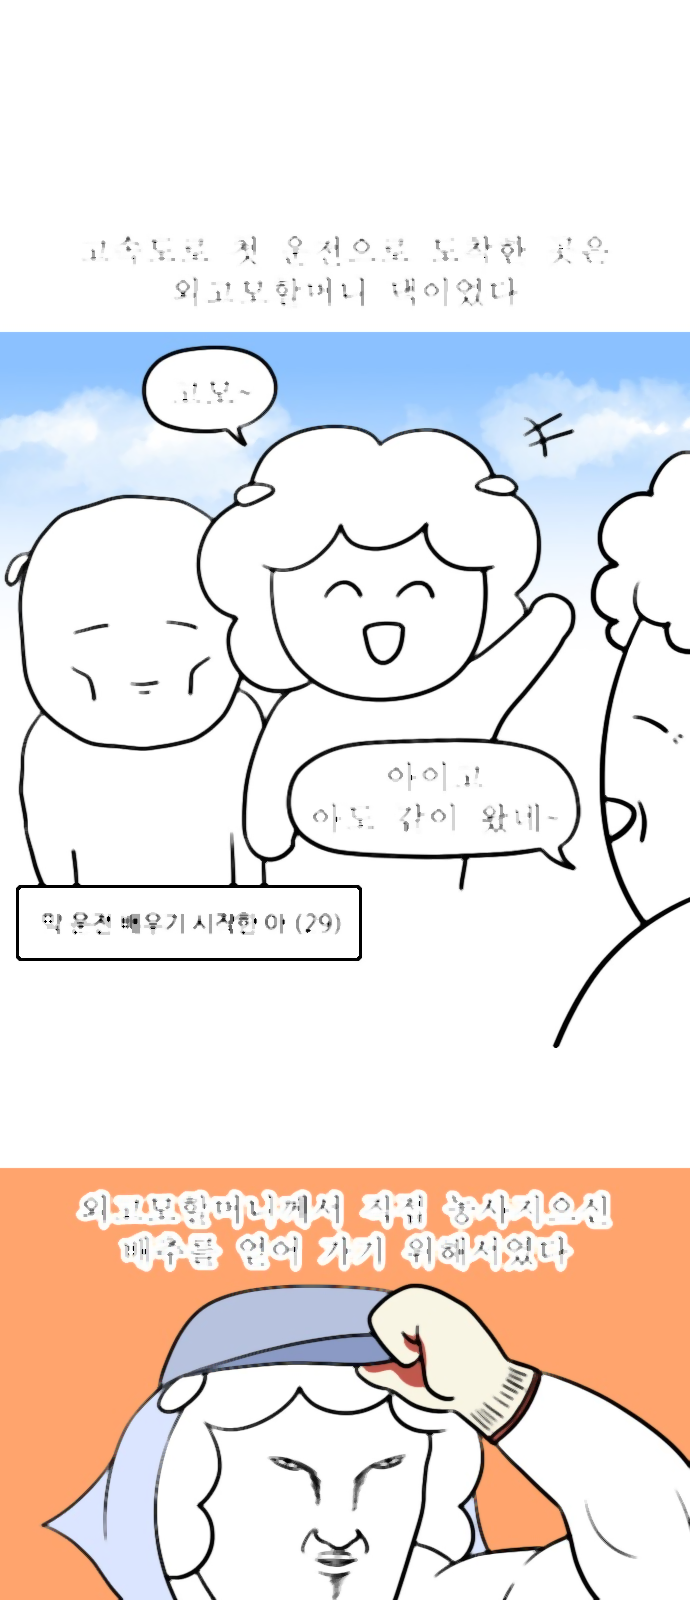

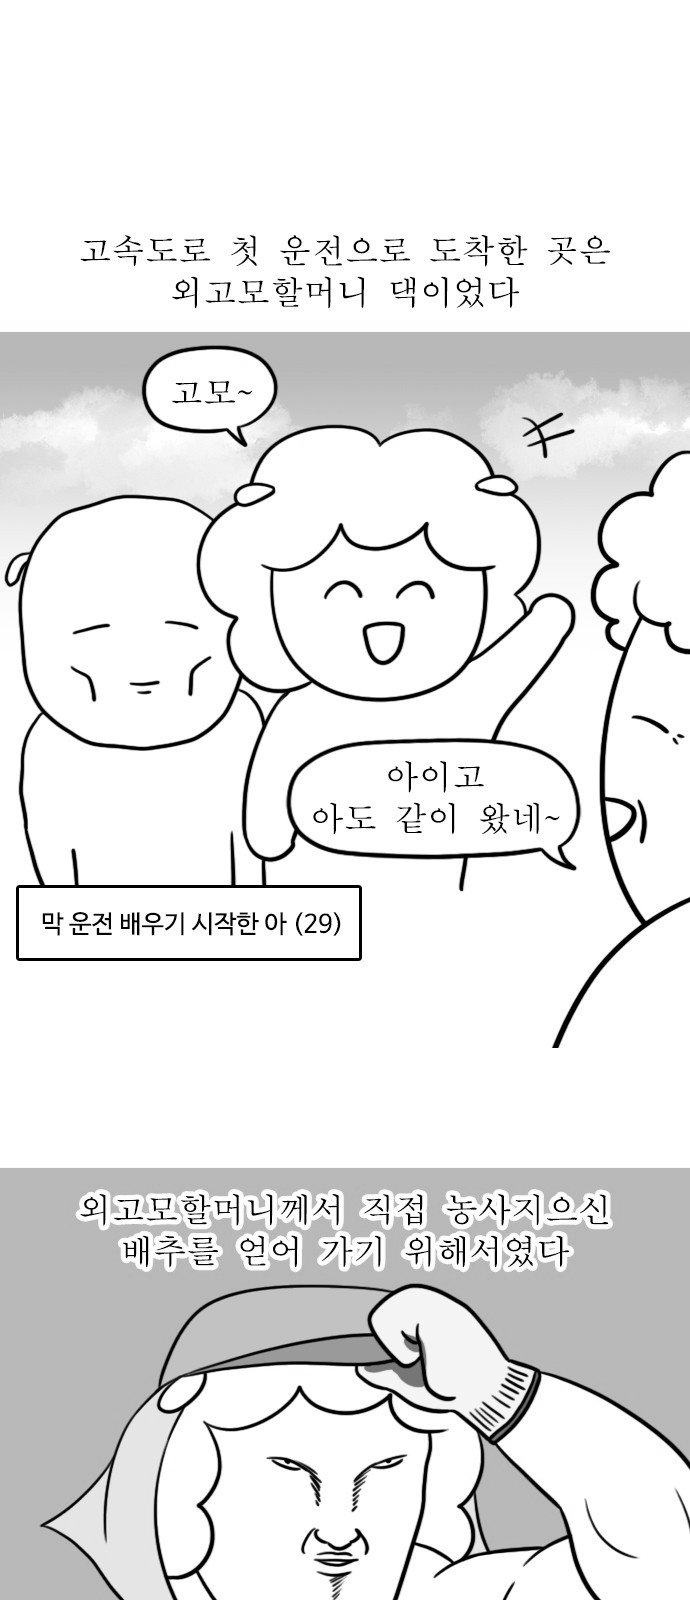

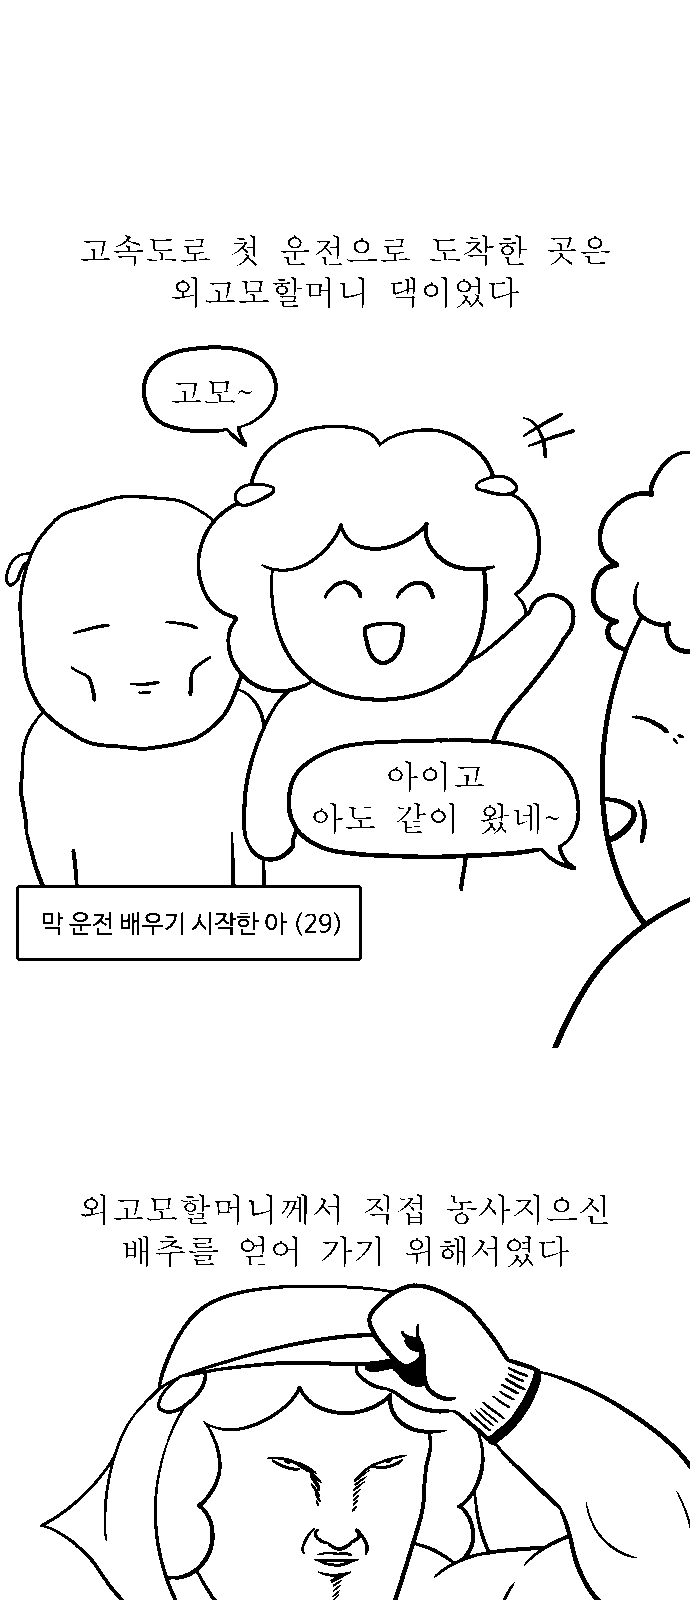

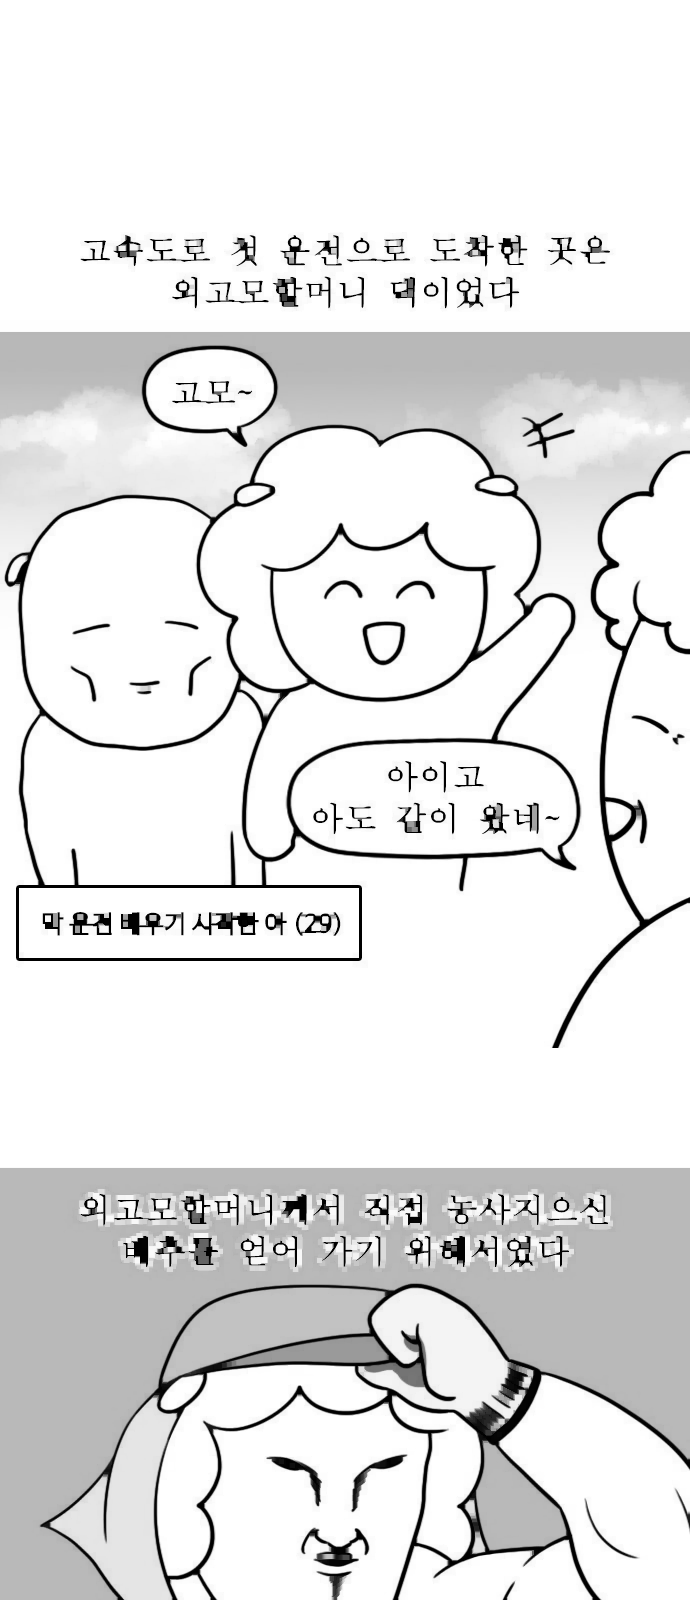

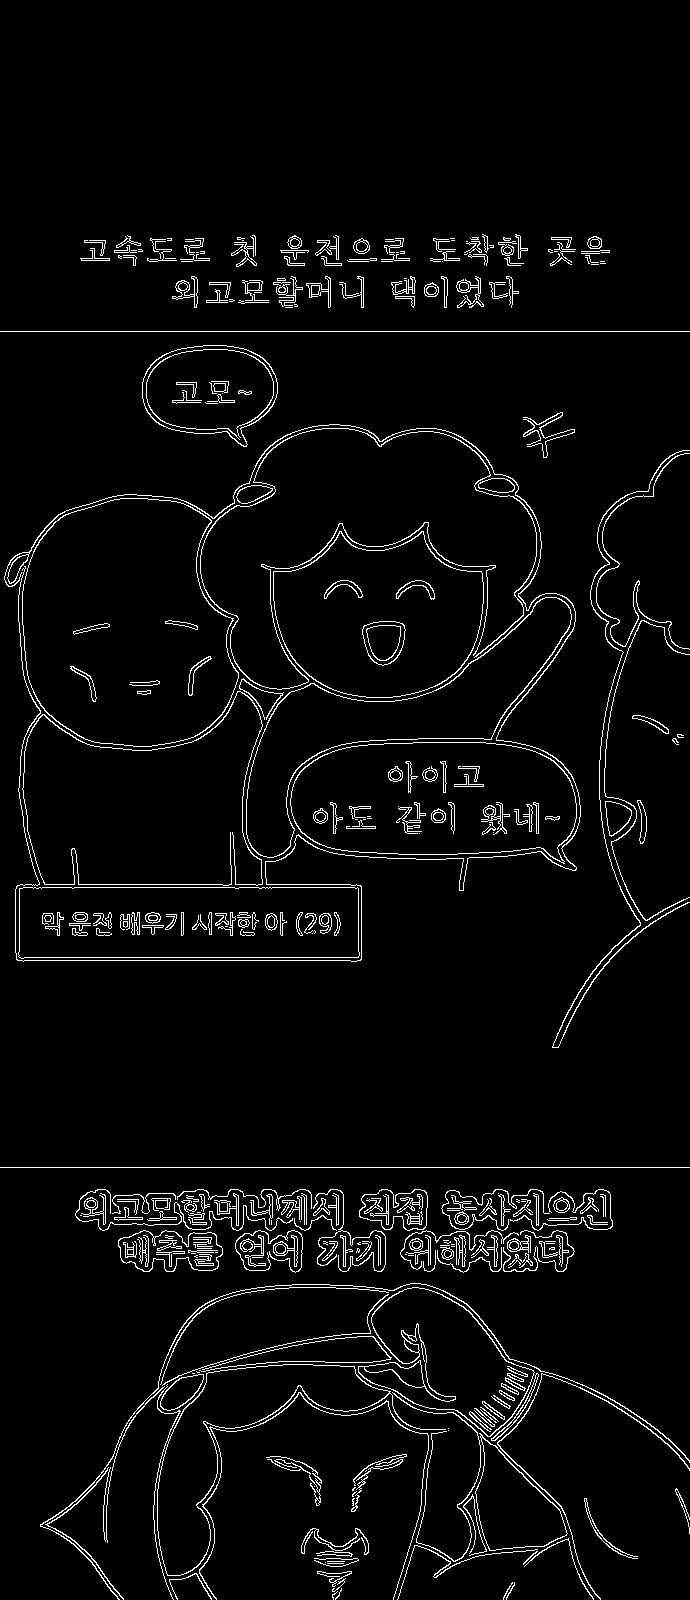

In [ ]:
cv2_imshow(noise)
cv2_imshow(gray)
cv2_imshow(thresh)
cv2_imshow(opening)
cv2_imshow(canny)

In [ ]:
images = [gray, thresh, opening, canny]

for image in images: 
  s = SequenceMatcher(lambda x: x == " ",
                    pytesseract.image_to_string(image, lang='kor', config = '--psm 11'),
                    actual_text)
  print(round(s.ratio(), 3))

0.487
0.506
0.736
0.169


So it looks like opening actually did a pretty good job lets look at both texts. 




In [ ]:
opening_text = pytesseract.image_to_string(image, lang='kor', config = '--psm 11')
print('Actual Text')
print('-' * 50)
print(actual_text)
print('Opening Text')
print('-' * 50)
print(opening_text)

Actual Text
--------------------------------------------------
고속도로 첫 운전으로 도착한 곳은 
외고모할머니 댁이었다 
고모~ 
아이고 
아도 같이 왔네~ 
막 운전 배우기 시작한 아 (29) 
외고모할머니께서 직접 농사지으신
베추를 얻어 가기 위해서였다
Opening Text
--------------------------------------------------
고속도로 첫 운전으

3

르

트리

럭

토고 틀이아

※

< 소!

">

하히고

개 기다 리미

킷

거버

시므으 시니어 들기 으으시

 에이

6

톰

토

ㄱ("

;

노

^

》

~



Ok... not what i was expecting the first line is almost correct but the rest looks in comprehendable but lets look at the changes it needs to make to be the actual text. 

In [ ]:
s = SequenceMatcher(lambda x: x == " ",
                    opening_text,
                    actual_text)
for tag, i1, i2, j1, j2 in s.get_opcodes():
    print('{:7}   a[{}:{}] --> b[{}:{}] {!r:>8} --> {!r}'.format(
         tag, i1, i2, j1, j2, opening_text[i1:i2], actual_text[j1:j2]))

equal     a[0:10] --> b[0:10] '고속도로 첫 운전으' --> '고속도로 첫 운전으'
insert    a[10:10] --> b[10:19]       '' --> '로 도착한 곳은 '
equal     a[10:11] --> b[19:20]     '\n' --> '\n'
insert    a[11:11] --> b[20:32]       '' --> '외고모할머니 댁이었다 '
equal     a[11:12] --> b[32:33]     '\n' --> '\n'
replace   a[12:13] --> b[33:37]      '3' --> '고모~ '
equal     a[13:14] --> b[37:38]     '\n' --> '\n'
insert    a[14:14] --> b[38:42]       '' --> '아이고 '
equal     a[14:15] --> b[42:43]     '\n' --> '\n'
replace   a[15:16] --> b[43:53]      '르' --> '아도 같이 왔네~ '
equal     a[16:17] --> b[53:54]     '\n' --> '\n'
insert    a[17:17] --> b[54:74]       '' --> '막 운전 배우기 시작한 아 (29) '
equal     a[17:18] --> b[74:75]     '\n' --> '\n'
replace   a[18:20] --> b[75:92]     '트리' --> '외고모할머니께서 직접 농사지으신'
equal     a[20:21] --> b[92:93]     '\n' --> '\n'
replace   a[21:53] --> b[93:101] '\n럭\n\n토고 틀이아\n\n※\n\n< 소!\n\n">\n\n하히고\n\n개 ' --> '베추를 얻어 가'
equal     a[53:54] --> b[101:102]      '기' --> '기'
insert    a[54:54] --> b[102:10

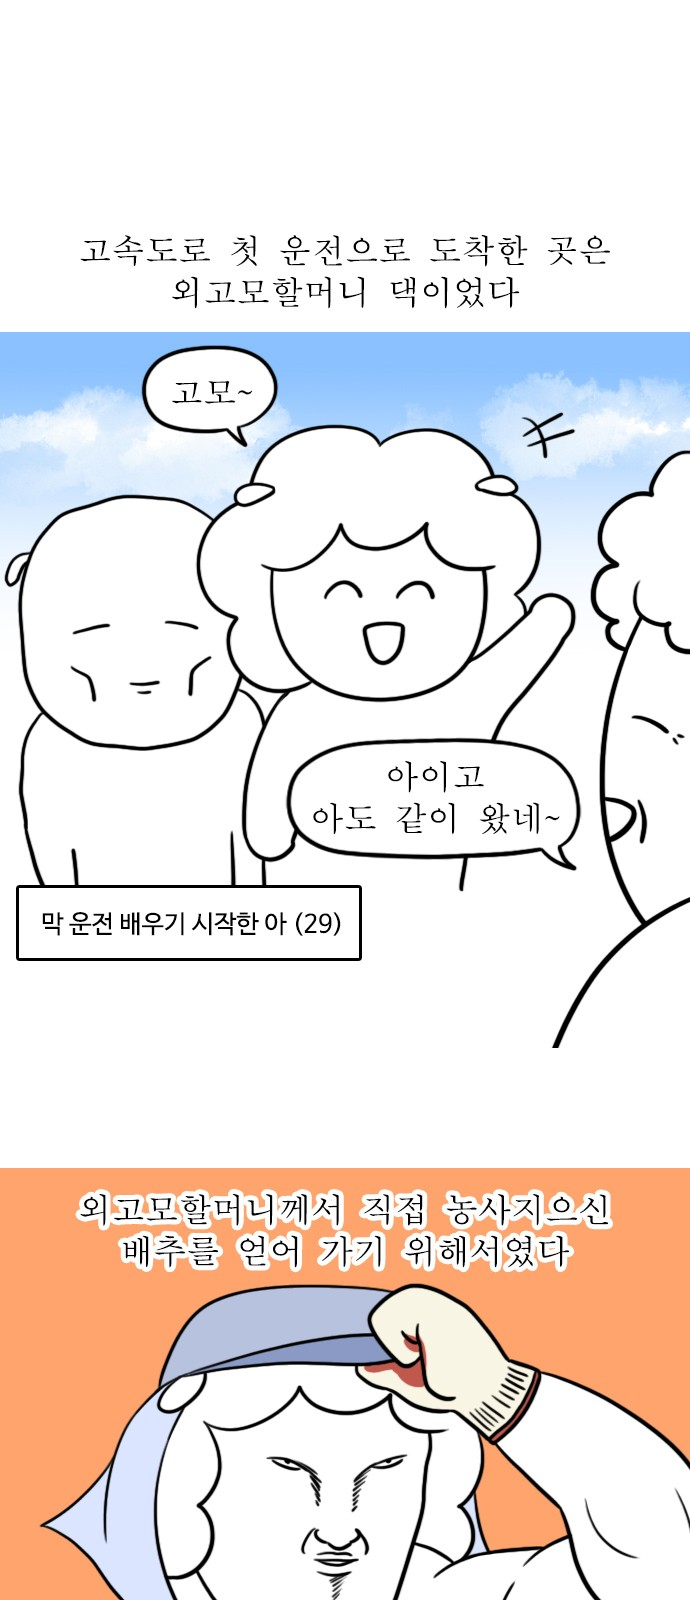

-1

In [ ]:
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
from pytesseract import Output

img = cv2.imread('sample.jpg')
d = pytesseract.image_to_data(img, output_type=Output.DICT, config='--psm 11', lang='kor')
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


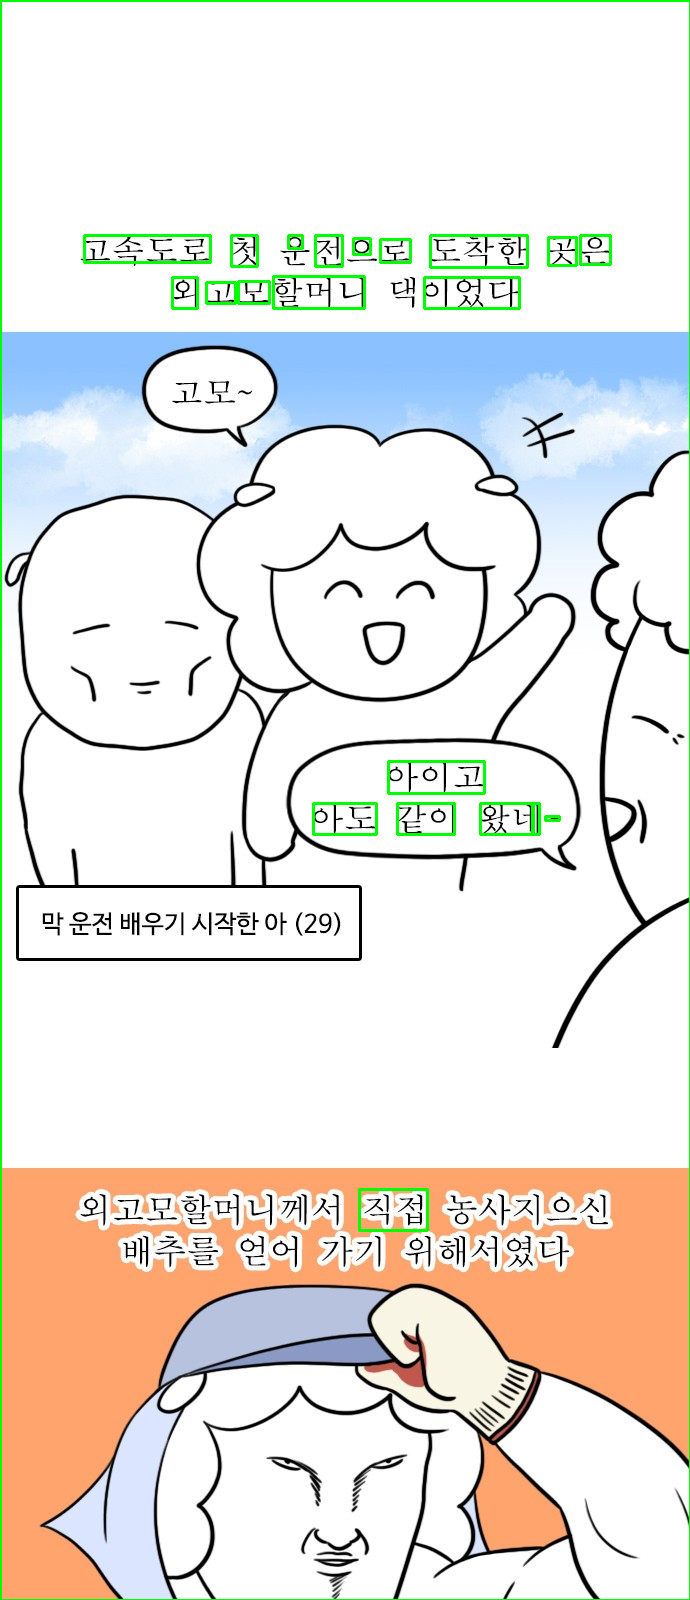

-1

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

OK! I am going to do some research on how to train a model so I can get some better results. 

Ok, I have begun making the files for my training data and interestingly tessaract was better at the recognition than pytessaract going to look into why that is. But I am still going to train the model so I can use it for this project.

OK it turns out that training the model was much more difficult than anticipated there was a lot of documentation but honestly not much made any sense. SO! We are going to try another library that I have found perhaps it will work a bit better. 

In [1]:
!pip install easyocr


     |████████████████████████████████| 63.6 MB 37 kB/s 
     |████████████████████████████████| 47.6 MB 48.0 MB/s 


In [3]:
import easyocr
reader = easyocr.Reader(['ko','en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [4]:
import urllib.request
from google.colab.patches import cv2_imshow
from difflib import SequenceMatcher

opener=urllib.request.build_opener()
opener.addheaders=[('User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)

urllib.request.urlretrieve("https://image-comic.pstatic.net/webtoon/748105/131/20211124111925_fa0d5663494d9ce21c0150859afffe18_IMAG01_1.jpg", "sample.jpg")


('sample.jpg', <http.client.HTTPMessage at 0x7f5c79b42f10>)

In [5]:
reader.readtext('sample.jpg', detail = 0)

['고속도로  첫  운전으로 도착한   곳은',
 '외고모할머니',
 '댁이없다',
 '고모~',
 '아이고',
 '아도   같이   앞네',
 '막 운전 배우기 시작한 아 (29)',
 '외고모할머니께서   직접 농사지으신',
 '배추름 얻어 가기 위해서엿다']

OK WOW! Looking at this it got the text almost exactly right except for one character of one syllable.... so it looks like we have our winner... going to make a new colab to use in order to create the actual corpus. 